<a href="https://colab.research.google.com/github/Schlager22/FDP_Course/blob/main/ML_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install nfl-data-py --quiet

In [2]:
import nfl_data_py as nfl
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import pyplot as plt

import warnings; warnings.simplefilter('ignore');

In [3]:
weekly_df = nfl.import_weekly_data(years=range(2000, 2022))

weekly_df.head()

Downcasting floats.


,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,00-0000003,None,Abdul-Karim al-Jabbar,RB,RB,None,IND,2000,1,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,-0.2,-0.2
1,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,1,REG,...,0.0,-0.312120,0,0.0,0.045455,0.0,0.0,0.0,0.3,1.3
2,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,12,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,1.8,1.8
3,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,14,REG,...,1.0,0.609493,0,0.0,0.071429,0.0,0.0,0.0,4.9,5.9
4,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,15,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,1.4,1.4


In [4]:
#filtering out positions we don't care about
eligible_positions = ['RB', 'WR', 'QB']
grouping_columns  = ['player_id', 'season']
features = ['targets', 'receptions', 'rushing_yards', 'receiving_yards', 'passing_yards']
target = ['position']

#filtering our data set
train_df = weekly_df.loc[weekly_df['position'].isin(eligible_positions), grouping_columns + features + target]

#group by week season, sum up feature columns, get back the player's position.
groupby_funcs = {
    'position': 'first'
}

for feature in features:
    groupby_funcs[feature] = np.sum

train_df = train_df.groupby(grouping_columns, as_index=False).agg(groupby_funcs)

#categorical variables -> numerical
train_df['position'] = train_df['position'].replace({
    'RB': 0,
    'WR': 1,
    'QB': 2
})

#dropna values in our dataset
train_df = train_df.dropna()

#also filter out players who just did not play
train_df = train_df.loc[(train_df['rushing_yards'] > 200) | (train_df['passing_yards'] > 300) | \
                        (train_df['receiving_yards'] > 150)]

train_df.head()

,player_id,season,position,targets,receptions,rushing_yards,receiving_yards,passing_yards
5,00-0000104,2000,2,0,0,13.0,0.0,1616.0
6,00-0000145,2000,1,134,72,45.0,1265.0,0.0
7,00-0000145,2001,1,68,27,16.0,470.0,0.0
9,00-0000210,2000,0,60,39,1106.0,291.0,0.0
10,00-0000210,2001,0,45,31,476.0,212.0,0.0


In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    train_df[features], #features
    train_df[target], #target
    test_size=0.2,
    random_state=123
)

In [6]:
# Create the decision tree classifier
clf = DecisionTreeClassifier(max_depth=2)
# The depth of a decision tree is important because it determines the level of complexity of the model

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the class labels for the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9825688073394495


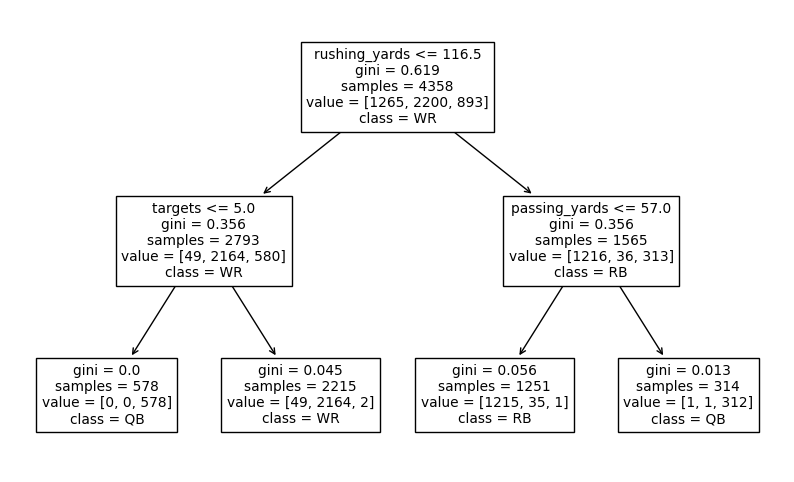

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

class_names = ['RB', 'WR', 'QB']
plot_tree(clf, ax=ax, feature_names=features, class_names=class_names);

In [9]:
# Specify the hyperparameters to optimize (determine max depth)
params = {'max_depth': range(1, 10),
          'min_samples_split': range(2, 6)}

clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, params, cv=10)
grid_search.fit(train_df[features], train_df[target])

best_clf = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params

# Number of sample splits prevents overfitting

{'max_depth': 6, 'min_samples_split': 4}

In [10]:
best_score

0.9823792498650838

In [11]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.994135,0.954930,0.974138,355.000000
1,0.967557,0.996071,0.981607,509.000000
2,1.000000,0.995575,0.997783,226.000000
accuracy,0.982569,0.982569,0.982569,0.982569
macro avg,0.987231,0.982192,0.984509,1090.000000
weighted avg,0.982940,0.982569,0.982528,1090.000000


In [ ]:
# Precision - Number of TP related to actual postives
# Recall - completeness of models poitive predicitions
# f1 Score - harmonic mean of precision and recall - combine metrics
# Support = number of samples
